##   Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Get Data Labels

In [2]:
classes=[]
filename='input'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## Resize images and put together Training and Testing Datasets

In [3]:
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 74/74 [00:00<00:00, 221.54it/s]


## Data augmentation and splitting

In [4]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

## Load Transfer Model

In [5]:
#load EfficientNet
from tensorflow.keras.applications import EfficientNetV2B0

EfficientNet=EfficientNetV2B0(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

#freeze base model
EfficientNet.trainable = False

## Train the model

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.random.set_seed(45)

#define model structure
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.33)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)

#optimizer
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
#print(model.summary())

# early stopping due to lack of improvement
early_stopping_cb= EarlyStopping(patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001)

#train the model
history1=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=50,batch_size=32,callbacks=[early_stopping_cb, reduce_lr])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.5115 - loss: 1.1504 - val_accuracy: 0.7816 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.7234 - loss: 0.6849 - val_accuracy: 0.8163 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.7586 - loss: 0.5916 - val_accuracy: 0.8102 - val_loss: 0.4656 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.7808 - loss: 0.5580 - val_accuracy: 0.8184 - val_loss: 0.4232 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.7957 - loss: 0.5282 - val_accuracy: 0.8327 - val_loss: 0.4120 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.7987 - loss: 0.5023 - val_accuracy: 0.8592 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.8049 - loss: 0.

## Unfreeze the model

In [7]:
EfficientNet.trainable = True
opt = Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
early_stopping_cb2= EarlyStopping(patience=5,restore_best_weights=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0000001)
history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=50,batch_size=32,callbacks=[early_stopping_cb2, reduce_lr2])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 99s 779ms/step - accuracy: 0.6875 - loss: 0.8392 - val_accuracy: 0.8673 - val_loss: 0.3437 - learning_rate: 1.0000e-04
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 814ms/step - accuracy: 0.8863 - loss: 0.3126 - val_accuracy: 0.8898 - val_loss: 0.2829 - learning_rate: 1.0000e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 782ms/step - accuracy: 0.9237 - loss: 0.2166 - val_accuracy: 0.9224 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 777ms/step - accuracy: 0.9632 - loss: 0.1269 - val_accuracy: 0.9286 - val_loss: 0.2111 - learning_rate: 1.0000e-04
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 776ms/step - accuracy: 0.9737 - loss: 0.0826 - val_accuracy: 0.9347 - val_loss: 0.1949 - learning_rate: 1.0000e-04
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 67s 768ms/step - accuracy: 0.9834 - loss: 0.0582 - val_accuracy: 0.9367 - val_loss: 0.1705 - learning_rate: 1.0000e-04
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 66s 760ms/step - acc

## Save Model & Plot Performance

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9289 - loss: 0.1913
Accuracy: 94.285715


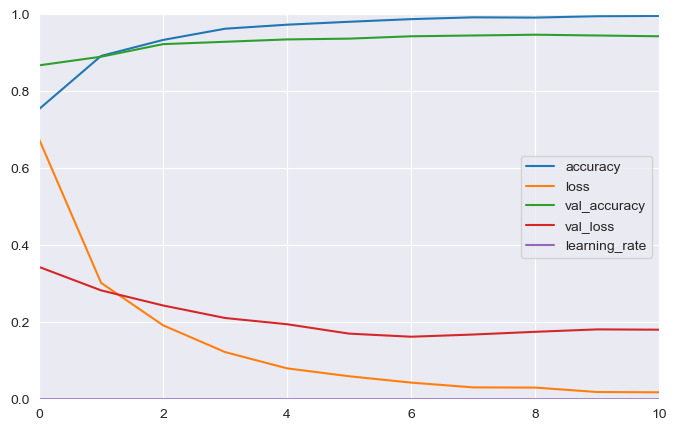

In [8]:
#save the model
model.save('models/Model4.keras')
model.save_weights('models/Model4.weights.h5')

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

plt.gca().set_xlim(0,10)
plt.gca().set_ylim(0,1)
plt.savefig('plots/Model4.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [9]:
#load the model
model=keras.models.load_model('models/Model4.keras')  
loss, accuracy = model.evaluate(X_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9289 - loss: 0.1913


## <font color='Aquamarine'>Accuracy and Loss</font> 

In [10]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 94.286 
 loss : 0.162


In [11]:

y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step


In [12]:
pd.Series(pred_labels).value_counts()

pituitary_tumor     140
meningioma_tumor    139
glioma_tumor        135
no_tumor             76
dtype: int64

## <font color='Aquamarine'>Confusion Matrix</font> 

Text(100.2222222222222, 0.5, 'Predicted class')

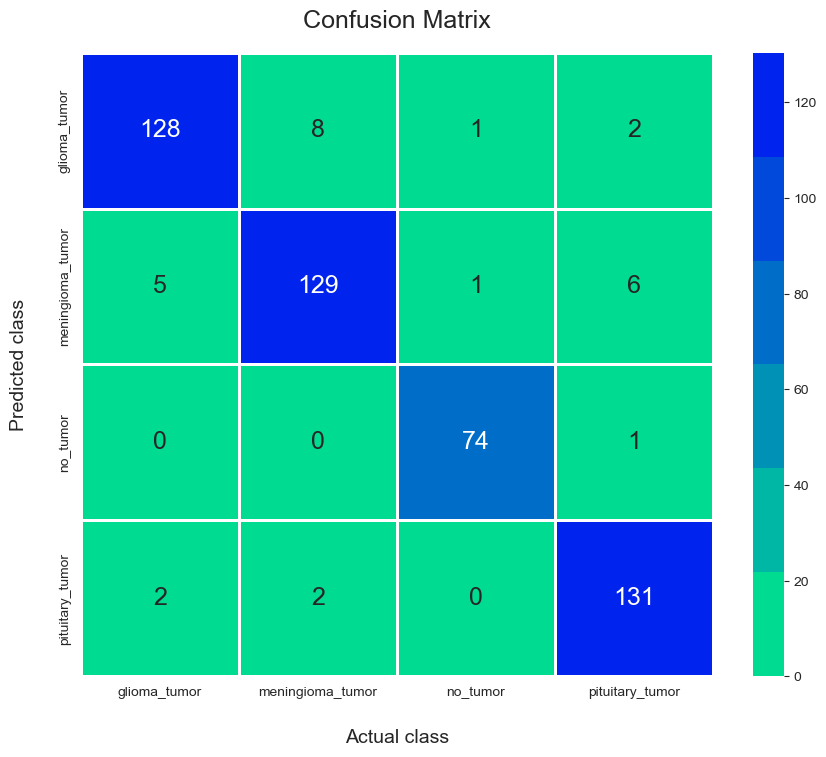

In [13]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

## <font color='Aquamarine'>Model performance scores</font> 

In [14]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.92      0.93       139
meningioma_tumor       0.93      0.91      0.92       141
        no_tumor       0.97      0.99      0.98        75
 pituitary_tumor       0.94      0.97      0.95       135

        accuracy                           0.94       490
       macro avg       0.95      0.95      0.95       490
    weighted avg       0.94      0.94      0.94       490


In [15]:
import matplotlib.image as mpimg
TEST_DIR='input/Testing'
#fetch images from the original validation dataset and resize them in order to plot the images.
images=[] 
n_classes=4
z_max=20
for i,filenames in enumerate(os.listdir(TEST_DIR)): 
    dir_fold=os.path.join(TEST_DIR, filenames)
    print(dir_fold)
    class_images=[]
    z=0
    for filename in os.listdir(dir_fold):
        if z < z_max:
            img_path = os.path.join(dir_fold, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            class_images.append(img)
            z+=1
        else:
            break
    images.append(class_images)
images=images[:20]


input/Testing\glioma_tumor
input/Testing\meningioma_tumor
input/Testing\no_tumor
input/Testing\pituitary_tumor


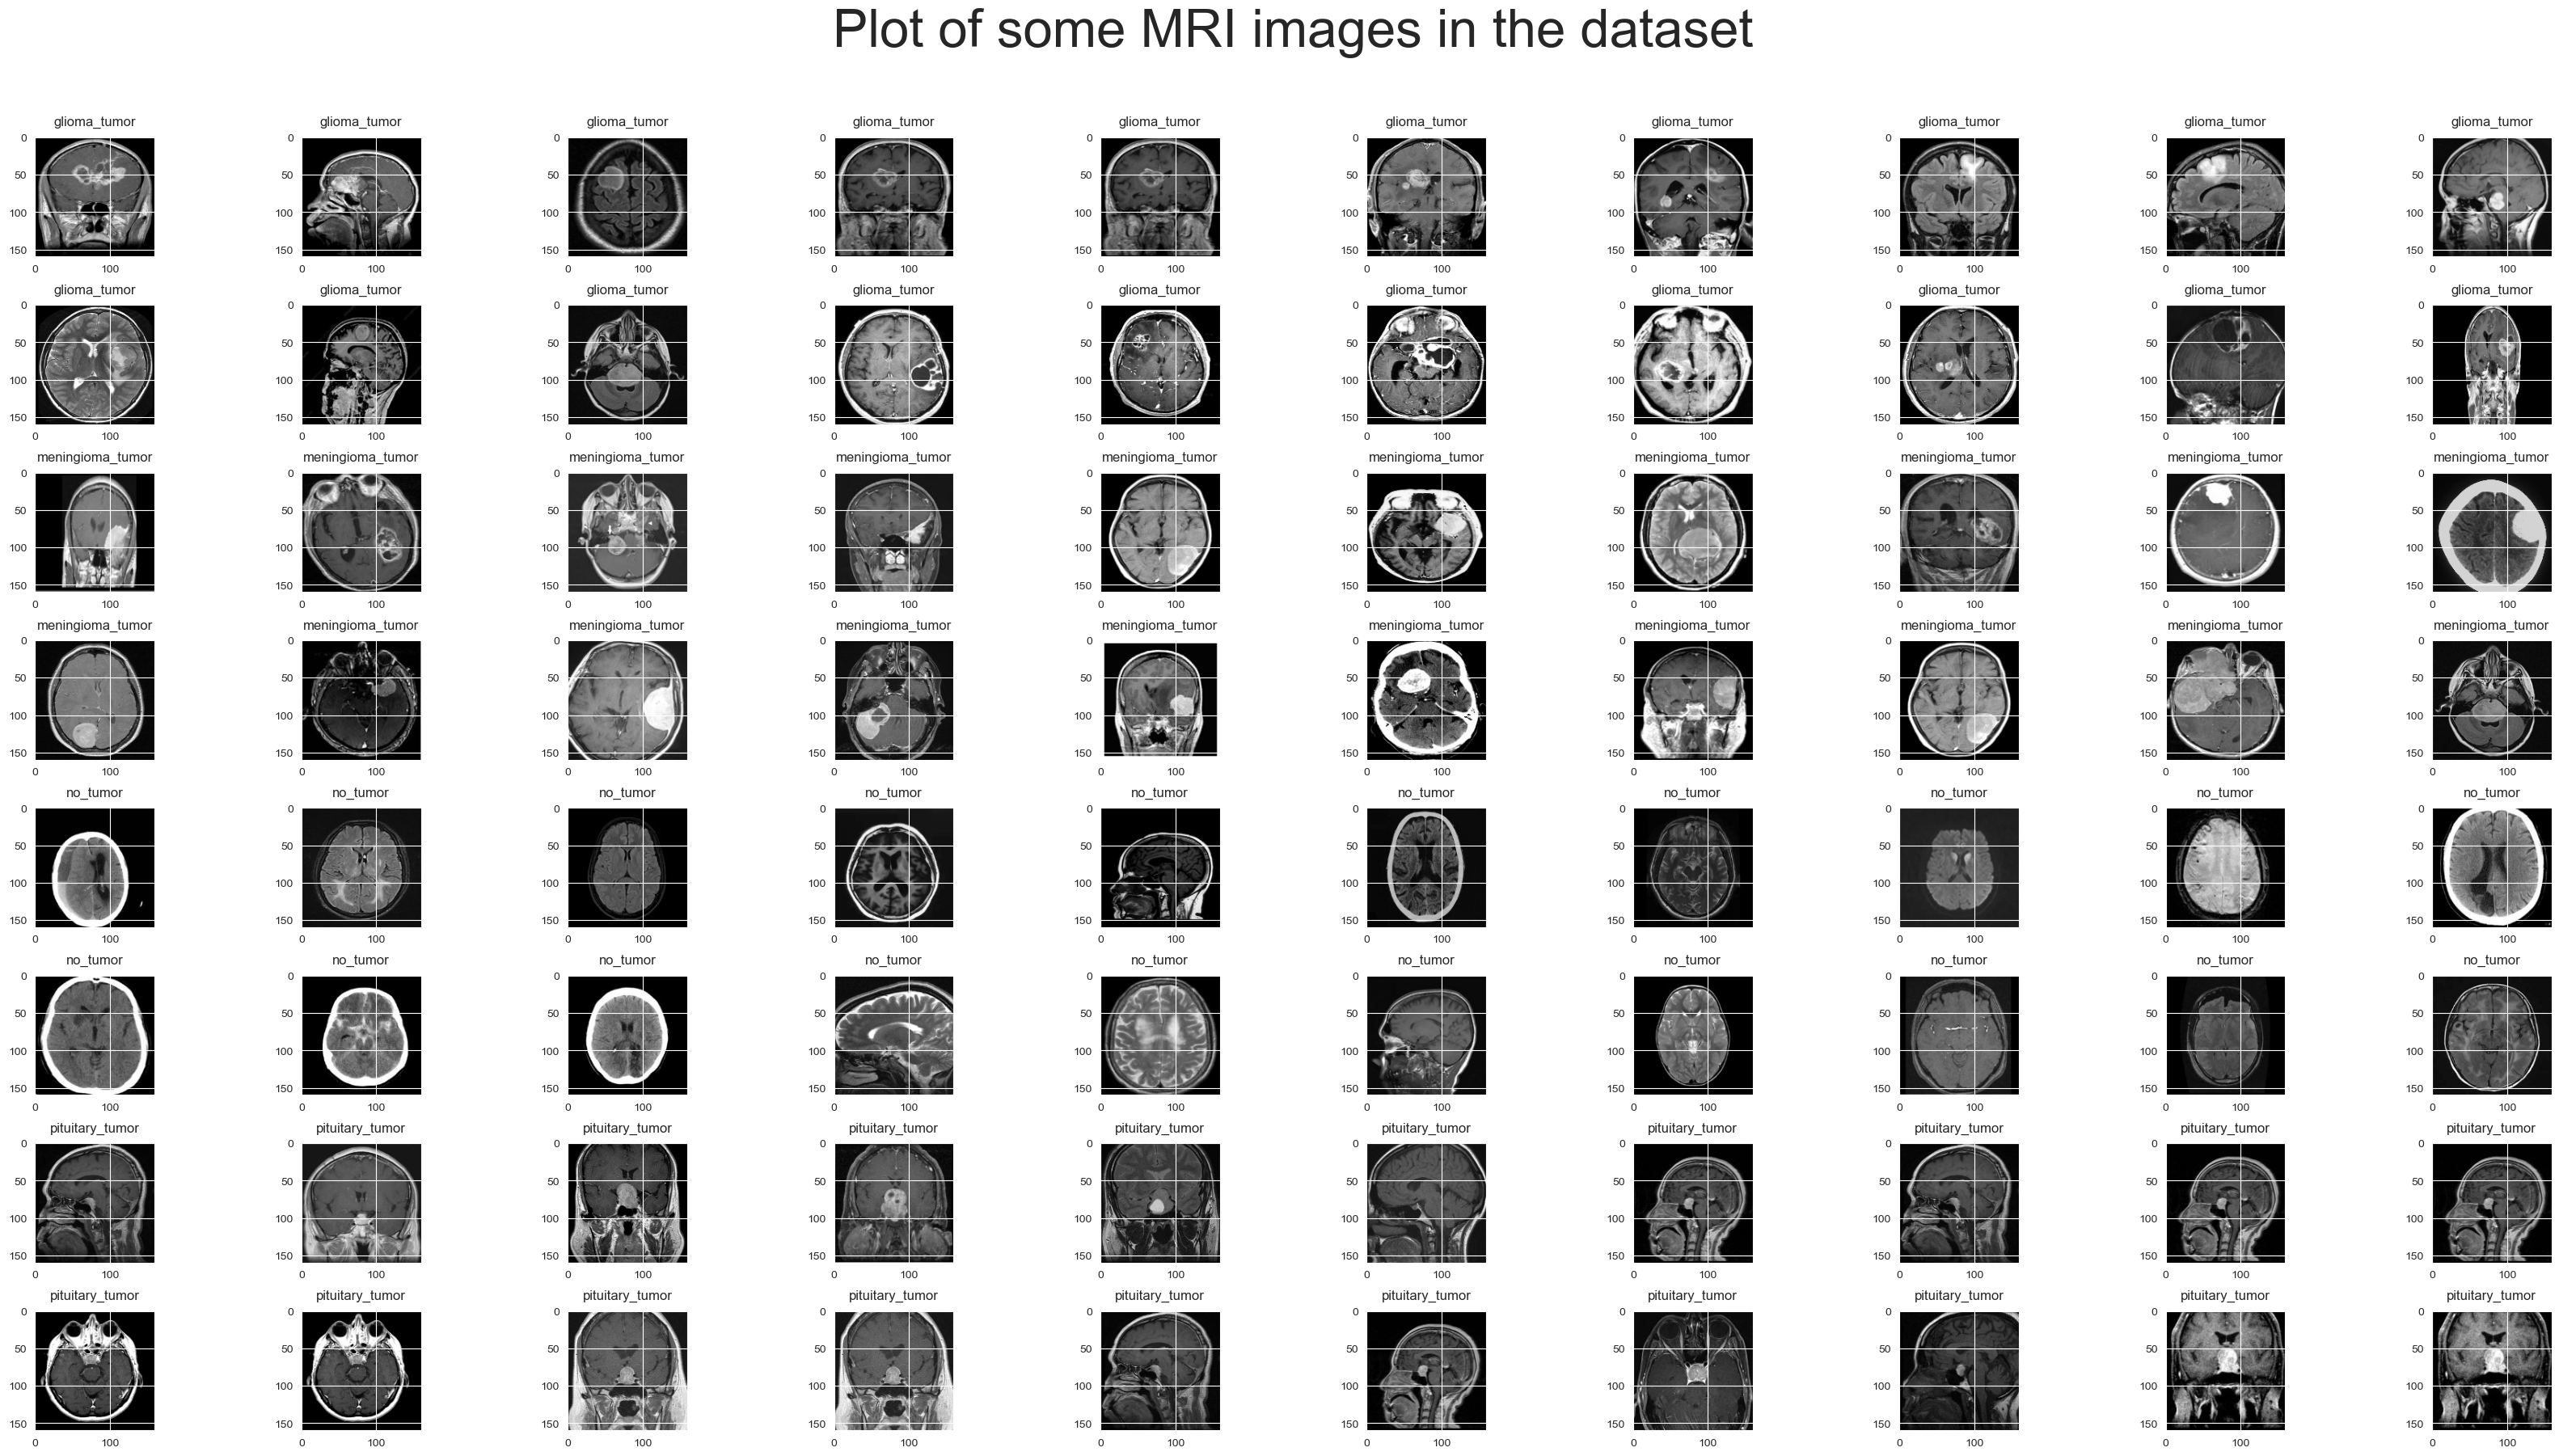

In [16]:
#here I plotted the images based on columns and z_max (defined by the user, 
#but it should be a multiple of the # of columns)
columns = 10
fig,axes=plt.subplots(int(len(images)*len(images[0])/columns),columns,figsize=(40,20))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i,ind in enumerate(images):
    #print(images_class)
    fig.suptitle('Plot of some MRI images in the dataset',fontsize=47)
    for j, image in enumerate(ind):
        #print(j,image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].imshow(image)
        axes[int((i)*(len(ind)/columns)+(int(j/columns))),j % columns].set_title(f'{classes[i]}',pad=10)
#image_plotting(X_test[:1])
#plt.savefig(os.path.join('plots/','Some_MRI_images_in_the_dataset_white.png'), dpi=300,facecolor='w')